In [1]:
from pmotifs.analysis_utilities.loading import Result
from pmotifs.config import config

GRAPHLET_SIZE = 3

r = Result.load_result(
    config.DATASET_DIRECTORY /  "yeastInter_st.txt",
    config.EXPERIMENT_OUT / "yeastInter_st",
    GRAPHLET_SIZE,
)

g = r.pmotif_graph
df = r.positional_metric_df

Loading graph modules: 100%|████████████████| 27/27 [00:00<00:00, 303609.14it/s]


In [2]:
randomized_results = Result.load_randomized_results(g, GRAPHLET_SIZE, supress_tqdm=True)

Loading Randomized Results: 100%|███████████| 100/100 [00:00<00:00, 8192.64it/s]


In [3]:
randomized_results = {
    r.pmotif_graph: r.positional_metric_df
    for r in randomized_results
}

# Analysis

In [4]:
METRIC_NAME = "degree"

In [5]:
# Extract Distribution of Metric for one dataframe
def extract_metric_distribution(df, metric_name):
    return dict(df.groupby("graphlet_class").agg(list)[metric_name])

extract_metric_distribution(df, METRIC_NAME)

{'011 100 100': [10,
  8,
  9,
  11,
  17,
  8,
  11,
  11,
  74,
  16,
  5,
  4,
  3,
  28,
  6,
  6,
  34,
  11,
  13,
  24,
  12,
  12,
  14,
  13,
  12,
  13,
  26,
  13,
  16,
  16,
  16,
  16,
  16,
  26,
  18,
  18,
  18,
  16,
  17,
  18,
  20,
  19,
  24,
  18,
  5,
  5,
  11,
  10,
  10,
  12,
  13,
  12,
  10,
  12,
  14,
  18,
  13,
  12,
  11,
  11,
  13,
  14,
  13,
  11,
  13,
  15,
  19,
  14,
  10,
  12,
  13,
  12,
  10,
  12,
  14,
  18,
  13,
  12,
  13,
  12,
  10,
  12,
  14,
  18,
  13,
  37,
  21,
  15,
  14,
  12,
  14,
  16,
  20,
  15,
  50,
  34,
  20,
  15,
  13,
  15,
  17,
  21,
  16,
  20,
  27,
  12,
  14,
  16,
  20,
  15,
  12,
  14,
  18,
  13,
  37,
  15,
  16,
  20,
  15,
  22,
  51,
  24,
  29,
  22,
  17,
  25,
  33,
  18,
  27,
  20,
  21,
  20,
  25,
  21,
  50,
  19,
  20,
  52,
  15,
  15,
  16,
  15,
  19,
  20,
  15,
  16,
  16,
  16,
  15,
  15,
  16,
  16,
  15,
  13,
  47,
  33,
  20,
  22,
  27,
  12,
  22,
  11,
  13,
  12,
  34,
  38,

In [6]:
df["nodes"]

0          [1, 199, 352]
1          [1, 199, 203]
2          [1, 199, 200]
3          [1, 199, 198]
4          [1, 199, 197]
              ...       
13145    [673, 678, 676]
13146    [673, 678, 675]
13147    [673, 677, 676]
13148    [673, 677, 675]
13149    [673, 676, 675]
Name: nodes, Length: 13150, dtype: object

In [7]:
CHOICE = [384, 389, 388]

In [8]:
def does_df_contain_motif(df, motif):
    motif = list(map(str, motif))
    return df[df["nodes"].isin([motif])].shape[0] > 0

CHOICE = list(map(str, CHOICE))
assert does_df_contain_motif(df, CHOICE), "Did not match an occurrence!"

In [9]:
graphlet_classes = list(df.groupby("graphlet_class").agg(lambda i: None).index)
graphlet_classes

['011 100 100', '011 101 110']

In [10]:
from scipy.stats import mannwhitneyu
from statistics import median
from tqdm import tqdm
import pandas as pd

from pmotifs.graphlet_representation import graphlet_class_to_name

original_distribution = extract_metric_distribution(df, METRIC_NAME)

data = {}
for graphlet_class in graphlet_classes:
    data[graphlet_class] = []
    for r_df in tqdm(randomized_results.values(), desc=f"Loading {graphlet_class}"):
        random_distribution = extract_metric_distribution(r_df, METRIC_NAME)

        mwu_result = mannwhitneyu(
            original_distribution[graphlet_class],
            random_distribution[graphlet_class],
        )

        data[graphlet_class].append({
           "u-statistic": mwu_result.statistic,
           "p-value": mwu_result.pvalue,
           "sample-size": len(random_distribution[graphlet_class]),
           "sample-median": median(random_distribution[graphlet_class]),
           "original-size": len(original_distribution[graphlet_class]),
           "original-median": median(original_distribution[graphlet_class]),
       })

result_dfs = {
    graphlet_class: pd.DataFrame(d)
    for graphlet_class, d in data.items()
}

Loading 011 101 110: 100%|███████████████████| 100/100 [00:00<00:00, 173.82it/s]


In [11]:
def echo_results(df, alpha_global=0.05):
    # Bonferroni Correction
    alpha_local = alpha_global / df.shape[0]

    rejected_rows = df[df["p-value"] < alpha_local]
    print(f"The original is not like the random in {rejected_rows.shape[0]} of {df.shape[0]} cases!")

In [12]:
import matplotlib.pyplot as plt

def plot_results(df, graphlet_class):
    fig, (size_ax, median_ax) = plt.subplots(1,2, figsize=(10, 5))

    df[["sample-size"]].plot.hist(ax=size_ax)
    size_ax.axvline(result_df["original-size"][0], label="original", color="tab:orange")
    size_ax.set_title("sample-size")
    size_ax.legend()
    size_ax.set_xlabel(METRIC_NAME)

    df[["sample-median"]].plot.hist(ax=median_ax)
    median_ax.axvline(result_df["original-median"][0], label="original", color="tab:orange")
    median_ax.set_title("sample-median")
    median_ax.legend()
    median_ax.set_xlabel(METRIC_NAME)
    
    fig.suptitle(graphlet_class_to_name(graphlet_class))

3-Dash
The original is not like the random in 100 of 100 cases!

Triangle
The original is not like the random in 100 of 100 cases!



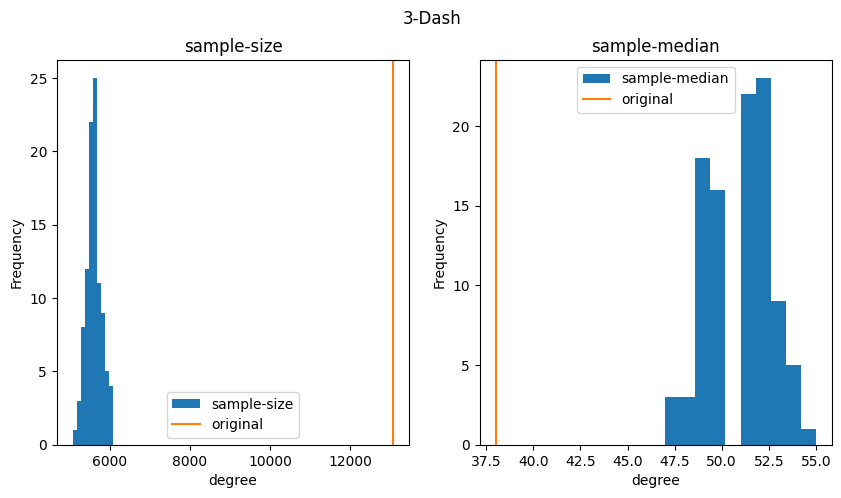

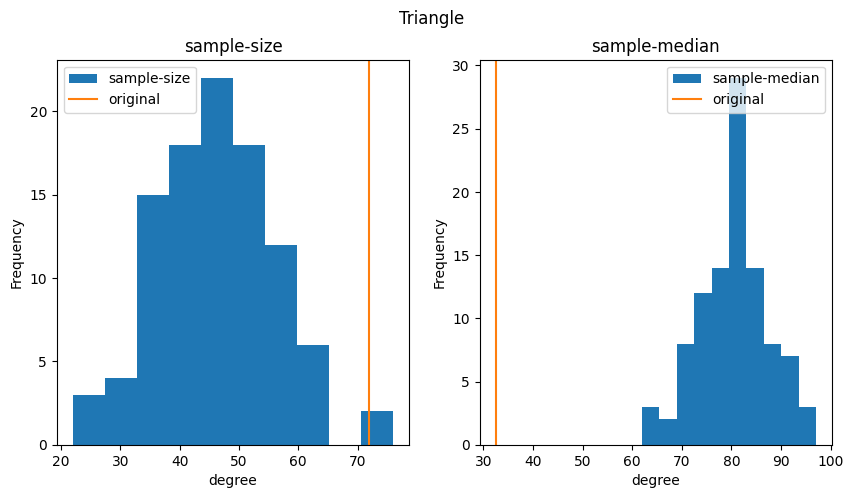

In [13]:
for graphlet_class, result_df in result_dfs.items():
    print(graphlet_class_to_name(graphlet_class))
    echo_results(result_df)
    plot_results(result_df,graphlet_class)
    print()